In [1]:
import pydicom
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

In [2]:
os.chdir('/Users/amitrc/Documents/Machine Learning/Data/rsna-pneumonia-detection-challenge')

In [3]:
TRAIN_IMAGES = 'stage_2_train_images'
SAVE_PATH = 'Processed'

### Get the labels

In [4]:
df_labels = pd.read_csv('stage_2_train_labels.csv')

#drop duplicates
df_labels = df_labels.drop_duplicates(['patientId']).reset_index()
df_labels.head()

,index,patientId,x,y,width,height,Target
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Display a few sample images

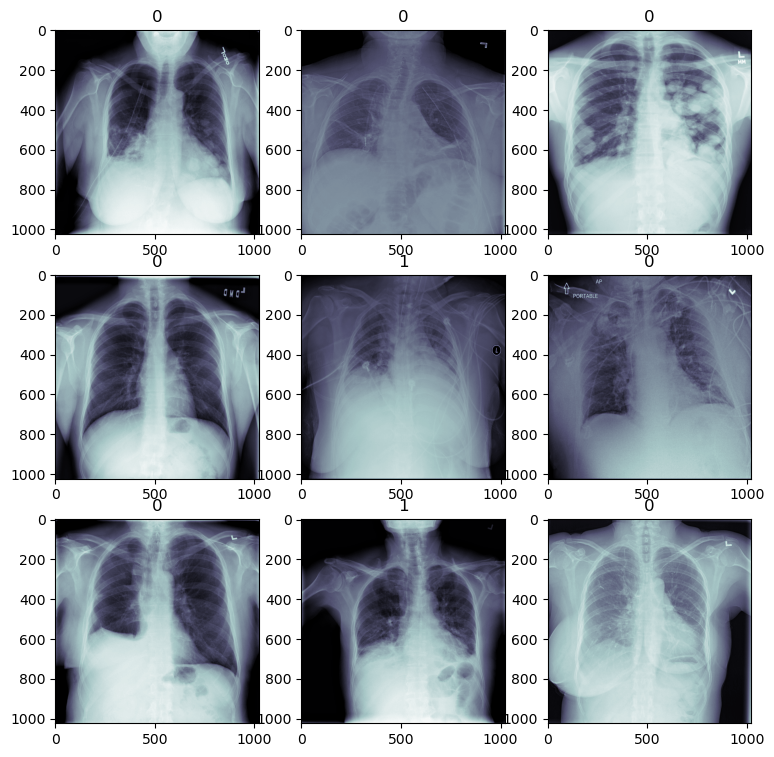

In [5]:
fig, ax = plt.subplots(3,3, figsize=(9,9))

c = 0

for i in range(3):
    for j in range(3):
        
        filename, label = df_labels[['patientId', 'Target']].iloc[c].values
        path = TRAIN_IMAGES + f'/{filename}.dcm'

        img = pydicom.read_file(path).pixel_array

        ax[i][j].imshow(img, cmap='bone')
        ax[i][j].set_title(label)

        c += 1

### Calculate the mean and standard deviation

In [50]:
sums, sums_squared = 0, 0
n_train = 24000
normalizer = 224 * 224

for c, filename in enumerate(tqdm(df_labels['patientId'])):

    path = TRAIN_IMAGES + f'/{filename}.dcm'
    label = df_labels['Target'].iloc[c]
    
    img = pydicom.read_file(path).pixel_array / 255
    img_array = cv2.resize(img, (224, 224)).astype(np.float16)
    
    train_or_val = 'train' if c < n_train else 'val'
        
    if c < n_train:
        sums += np.sum(img_array) / normalizer
        sums_squared += (img_array ** 2).sum() / normalizer
        
    path = SAVE_PATH + f'/{train_or_val}/{label}'
    os.makedirs(path, exist_ok=True)
    np.save(path + f'/{filename}', img_array)
            

100%|████████████████████████████████████| 26684/26684 [02:06<00:00, 211.77it/s]


In [51]:
mean = sums / n_train
std = np.sqrt((sums_squared / n_train) - mean ** 2)

mean, std

(0.49039623525191567, 0.2479507326197431)

# Start of training

In [6]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

### Create the datasets

In [7]:
def load_file(path):
    
    return np.load(path).astype(np.float32)

In [8]:
train_transforms = transforms.Compose(
                        [transforms.ToTensor(),
                         transforms.Normalize(0.49, 0.24),
                         transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
                         transforms.RandomResizedCrop(size=(224,224), scale=(0.35, 1))])

val_transforms = transforms.Compose(
                        [transforms.ToTensor(),
                         transforms.Normalize(0.49, 0.24)])

In [9]:
train_dataset = DatasetFolder(SAVE_PATH + '/train', loader=load_file, extensions='npy', transform=train_transforms)

val_dataset = DatasetFolder(SAVE_PATH + '/val', loader=load_file, extensions='npy', transform=val_transforms)

Check a few sample augmented images

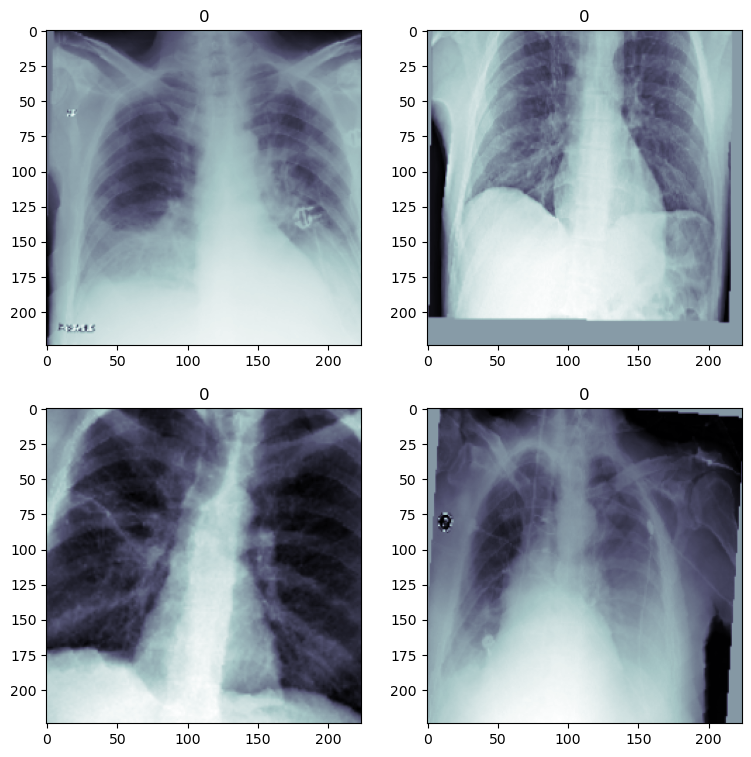

In [11]:
fig, ax = plt.subplots(2,2,figsize=(9,9))

for i in range(2):
    for j in range(2):
        rand_idx = np.random.randint(0, 24000)
        img, label = train_dataset[rand_idx]
        ax[i][j].imshow(img[0], cmap='bone')
        ax[i][j].set_title(label)

In [13]:
BATCH_SIZE=64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# The data is quite imbalanced
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

## Define the model

In [15]:
torchvision.models.resnet18();

In [16]:
class Pneumonia(pl.LightningModule):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        
        
    def forward(self, data):
        
        return self.model(data)
    
    
    def training_step(self, batch, batch_idx):
        
        X, label = batch
        label = label.float()
        
        pred = self(X)[:,0]
        
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    def on_train_epoch_end(self, *arg, **kwargs):
        
        self.log("Train Acc", self.train_acc().compute())
        
                
    def validation_step(self, batch, batch_idx):
        
        X, label = batch
        label = label.float()
        
        pred = self(X)[:,0]
        
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        
        return loss
        
    def on_validation_epoch_end(self, *arg, **kwargs):
        
        self.log("Val Acc", self.val_acc.compute())

        
    def configure_optimizers(self):
        
        return [self.optimizer]
        
        

In [199]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
                

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def on_training_epoch_end(self, *arg, **kwargs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def on_validation_epoch_end(self, *arg, **kwargs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



## Trainer

In [17]:
model = Pneumonia()

In [18]:
checkpoint_callback = ModelCheckpoint(monitor="Val Acc", save_top_k=10, mode="max")

In [19]:
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir='./logs'),
                     log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=35)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/amitrc/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/amitrc/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Users/amitrc/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

TypeError: BinaryStatScores.update() missing 2 required positional arguments: 'preds' and 'target'